# Name: Luke Pratley

## Statistical analysis of IoU scores
The metric used to compare the detection against the ground truth is the [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) or IoU. It is a measure of how much the detection and ground truth labels overlap. The IoU is calculated as $${\rm IoU} = \frac{|Y \cap \hat{Y}|}{|Y \cup \hat{Y}|}\, $$ where $Y$ is the set of predicted classifications and $\hat{Y}$ is the set of ground truth classifications, and $|\cdot|$ is the cardinally of a set.

A high IoU score suggests that the predicted and the ground truth extracted features overlap, while a low IoU score suggests they do not.

First we import some libraries that we will find useful:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

import pickle
import itertools

Here we are opening the measured IoU metrics that have been saved from the trained models:

In [2]:
with open('iou_metric_test_results.pkl', 'rb') as file:
    model_metrics = pickle.load(file)
  

In [3]:
models = list(model_metrics.keys())
iou_info = list(model_metrics[models[0]].keys())
areas_of_interest = list(model_metrics[models[0]][iou_info[0]].keys())

The models are:

In [4]:
models

['efficient_model_dice',
 'efficient_model_entropy',
 'model_dice',
 'model_entropy',
 'res_model_dice',
 'res_model_entropy',
 'attention_model_dice',
 'attention_model_entropy']

Information relating to the IoU metrics that we have loaded. We have the file path for each road and building IoU metric and the corresponding index for that file.

In [5]:
iou_info

['road_iou',
 'building_iou',
 'road_file',
 'road_index',
 'building_file',
 'building_index']

We have the area of interest for the particular IoU that was measured:

In [6]:
areas_of_interest

['AOI_2_Vegas', 'AOI_3_Paris', 'AOI_4_Shanghai', 'AOI_5_Khartoum']

In [ ]:
def plot_metrics(model_metrics, model_name):
    """
    A function that plots the IoU metrics 
    for each model and area of interest 
    for roads and buildings.
    
    Inputs:
        model_metrics: the dictionary containing the saved IoU scores for each image.
        model_name: the name of the model which is used as a dictionary key for model_metrics
    """
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 2))
    plt.suptitle(f'Road Average IoU per Image ({model_name})')
    ax = np.ravel(ax)
    all_values = []
    for k, key in enumerate(model_metrics[model_name]['road_iou'].keys()):
        all_values = np.concatenate((all_values, model_metrics[model_name]['road_iou'][key]))
        model_metrics[model_name]['road_iou'][key] = np.array(model_metrics[model_name]['road_iou'][key])   
        ax[k].hist(model_metrics[model_name]['road_iou'][key], density=True, alpha=0.5, bins=np.arange(0, 1.05, 0.05), label=key, color=['green', 'red', 'navy', 'purple'][k])
        ax[k].legend()
        ax[k].set_xlabel('IoU')
        ax[k].axvline(np.median(model_metrics[model_name]['road_iou'][key]))
    print(f'The median IoU for roads is {np.median(all_values): 0.4f}')
    ax[0].set_ylabel('Density')
    plt.show()
    all_values = []
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 2))
    fig.suptitle(f'Building Average IoU per Image ({model_name})')
    ax = np.ravel(ax)
    for k, key in enumerate(model_metrics[model_name]['building_iou'].keys()):
        all_values = np.concatenate((all_values, model_metrics[model_name]['building_iou'][key]))
        model_metrics[model_name]['building_iou'][key] = np.array(model_metrics[model_name]['building_iou'][key])
        ax[k].hist(model_metrics[model_name]['building_iou'][key], density=True, alpha=0.5, bins=np.arange(0, 1.05, 0.05), label=key, color=['green', 'red', 'navy', 'purple'][k])
        ax[k].legend()
        ax[k].set_xlabel('IoU')
        ax[k].axvline(np.median(model_metrics[model_name]['building_iou'][key]))
    print(f'The median IoU for buildings is {np.median(all_values): 0.4f}')
    ax[0].set_ylabel('Density')
    plt.show()

Here we plot histograms of the results calculated above. The vertical blue line shows the location of the median IoU for each area of interest.

The printed out IoU value is the median for all images in the dataset.

In [ ]:
for model_name in model_configurations.keys():
        print(model_name, model_configurations[model_name])
        plot_metrics(model_metrics, model_name)

Above we can compare see a comparison for the distribution of IoU scores per an image, between areas of interest for both building and road extraction. While the building detection has a higher median IoU score than road detection, the IoU distribution varies from city to city. For example, Paris and Shanghai are particularly challenging in detecting buildings with their median IoU scores appearing closer to 0.5. However, Las Vegas shows a stronger performance with its IoU score distribution for both roads and buildings with a higher median score and with less scatter in the IoU distribution.

Now we are creating a list of unique pairs for the model comparisons:

In [7]:
pairs = list(itertools.product(models, models))
for p in pairs:
    p2 = (p[1], p[0])
    if p2 in pairs:
        pairs.remove(p)

In [8]:
print(f'There are {len(pairs)} model pairs that are unique.')

There are 38 model pairs that are unique.


## Comparison of models by Area of Interest and by category (e.g., road or building extraction)

Below we plot out the histogram of IoU (per image) for the test data set. We compare models pairwise and set the alpha value of each histogram to 0.5. The overlapping region is darker making it easier to see the difference in the lighter regions.

We also record the pairwise p-value using Student's t-test. The null hypothesis is that one model has an average IoU is less than or equal to the other model. If the p-value is less than 0.05, we can reject the null-hypothesis and conclude that one model has a larger IoU than the other on average. For obvious reasons, we only perform the test for the case where the mean IoU of one model is greater than the other model.

### Roads

We first compare the IoU for extracted roads and then we can compare the IoU for extracted buildings:

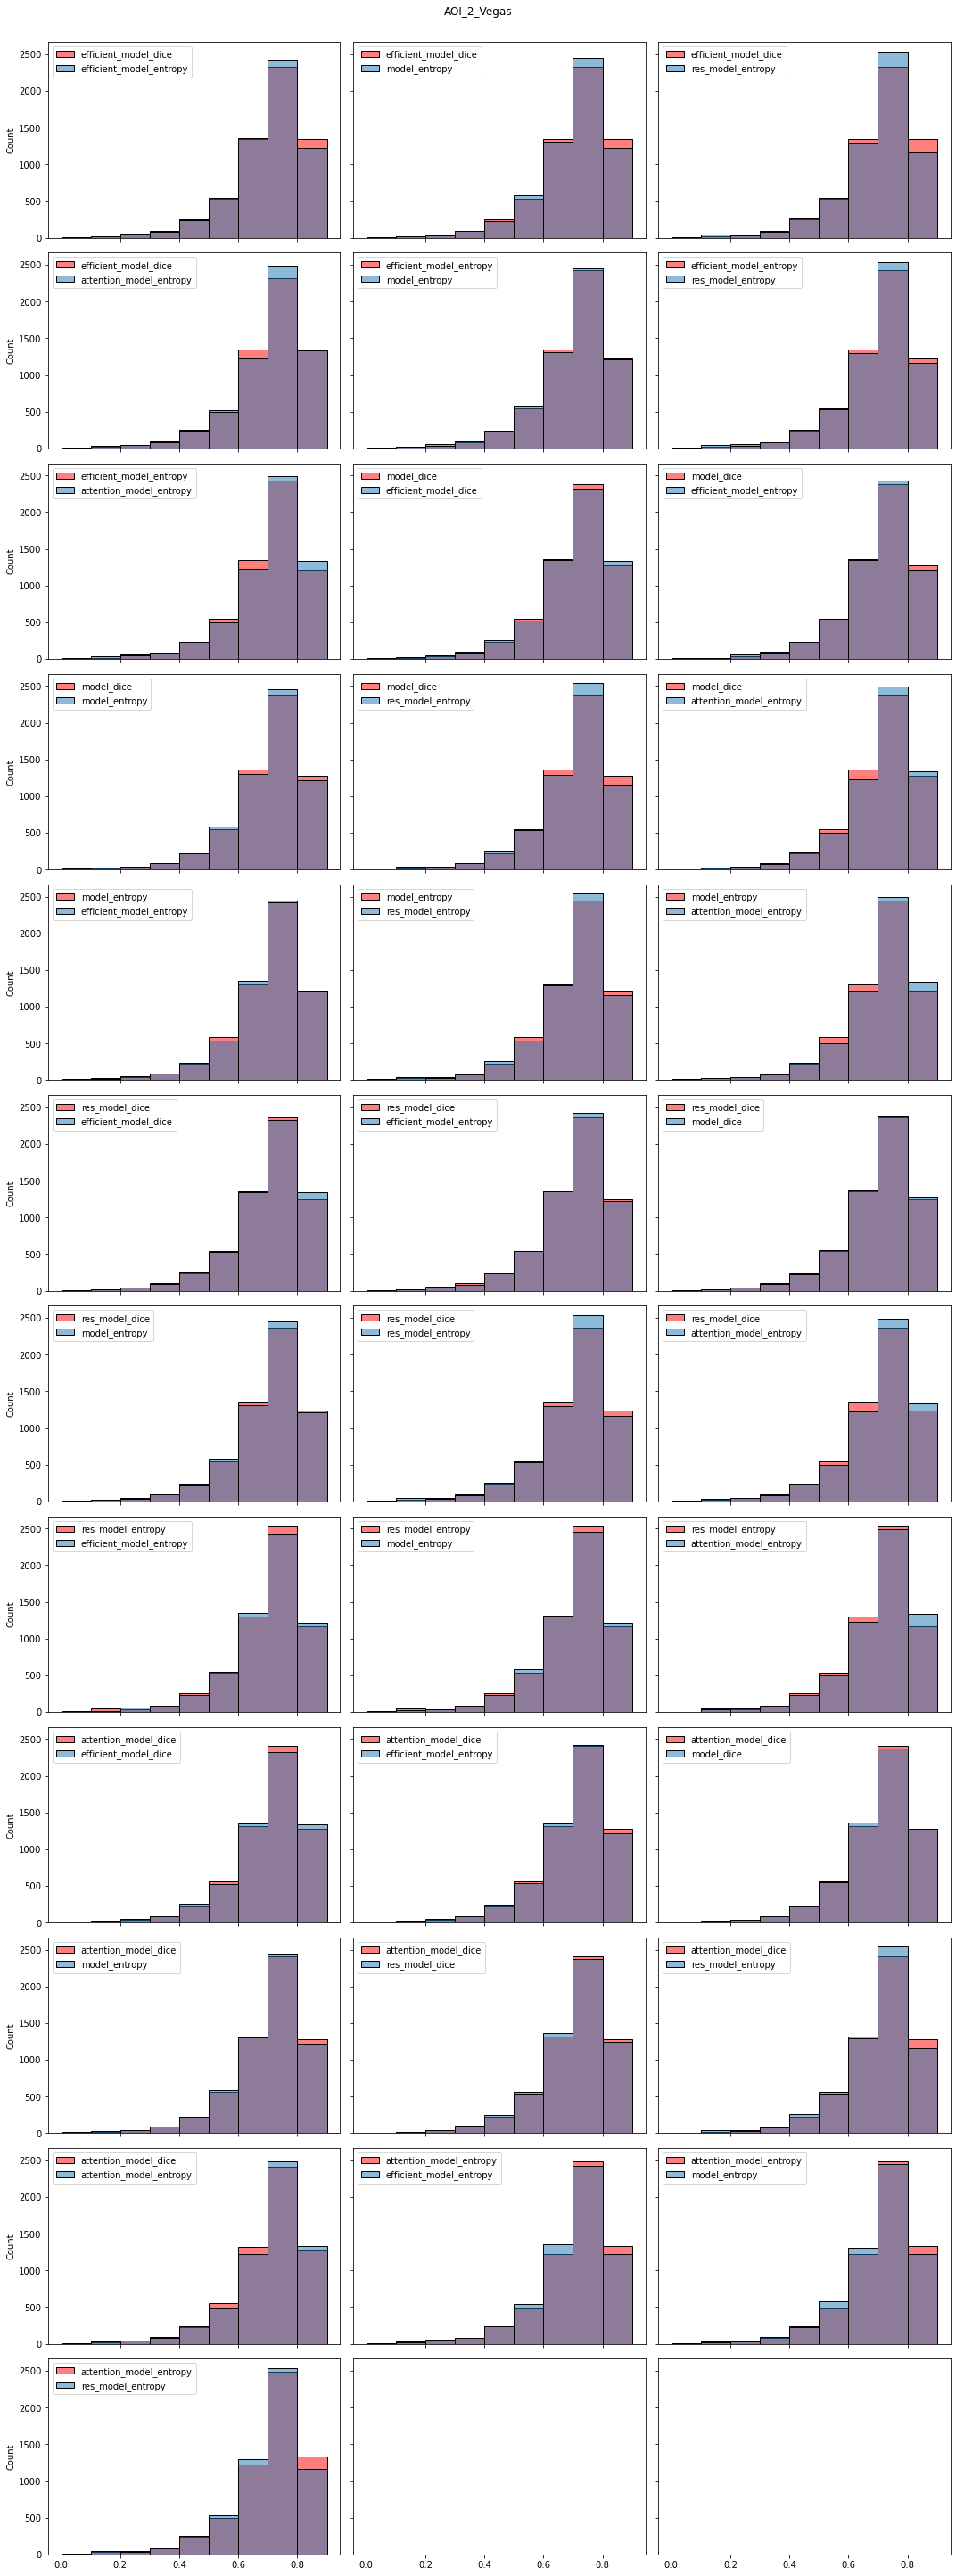

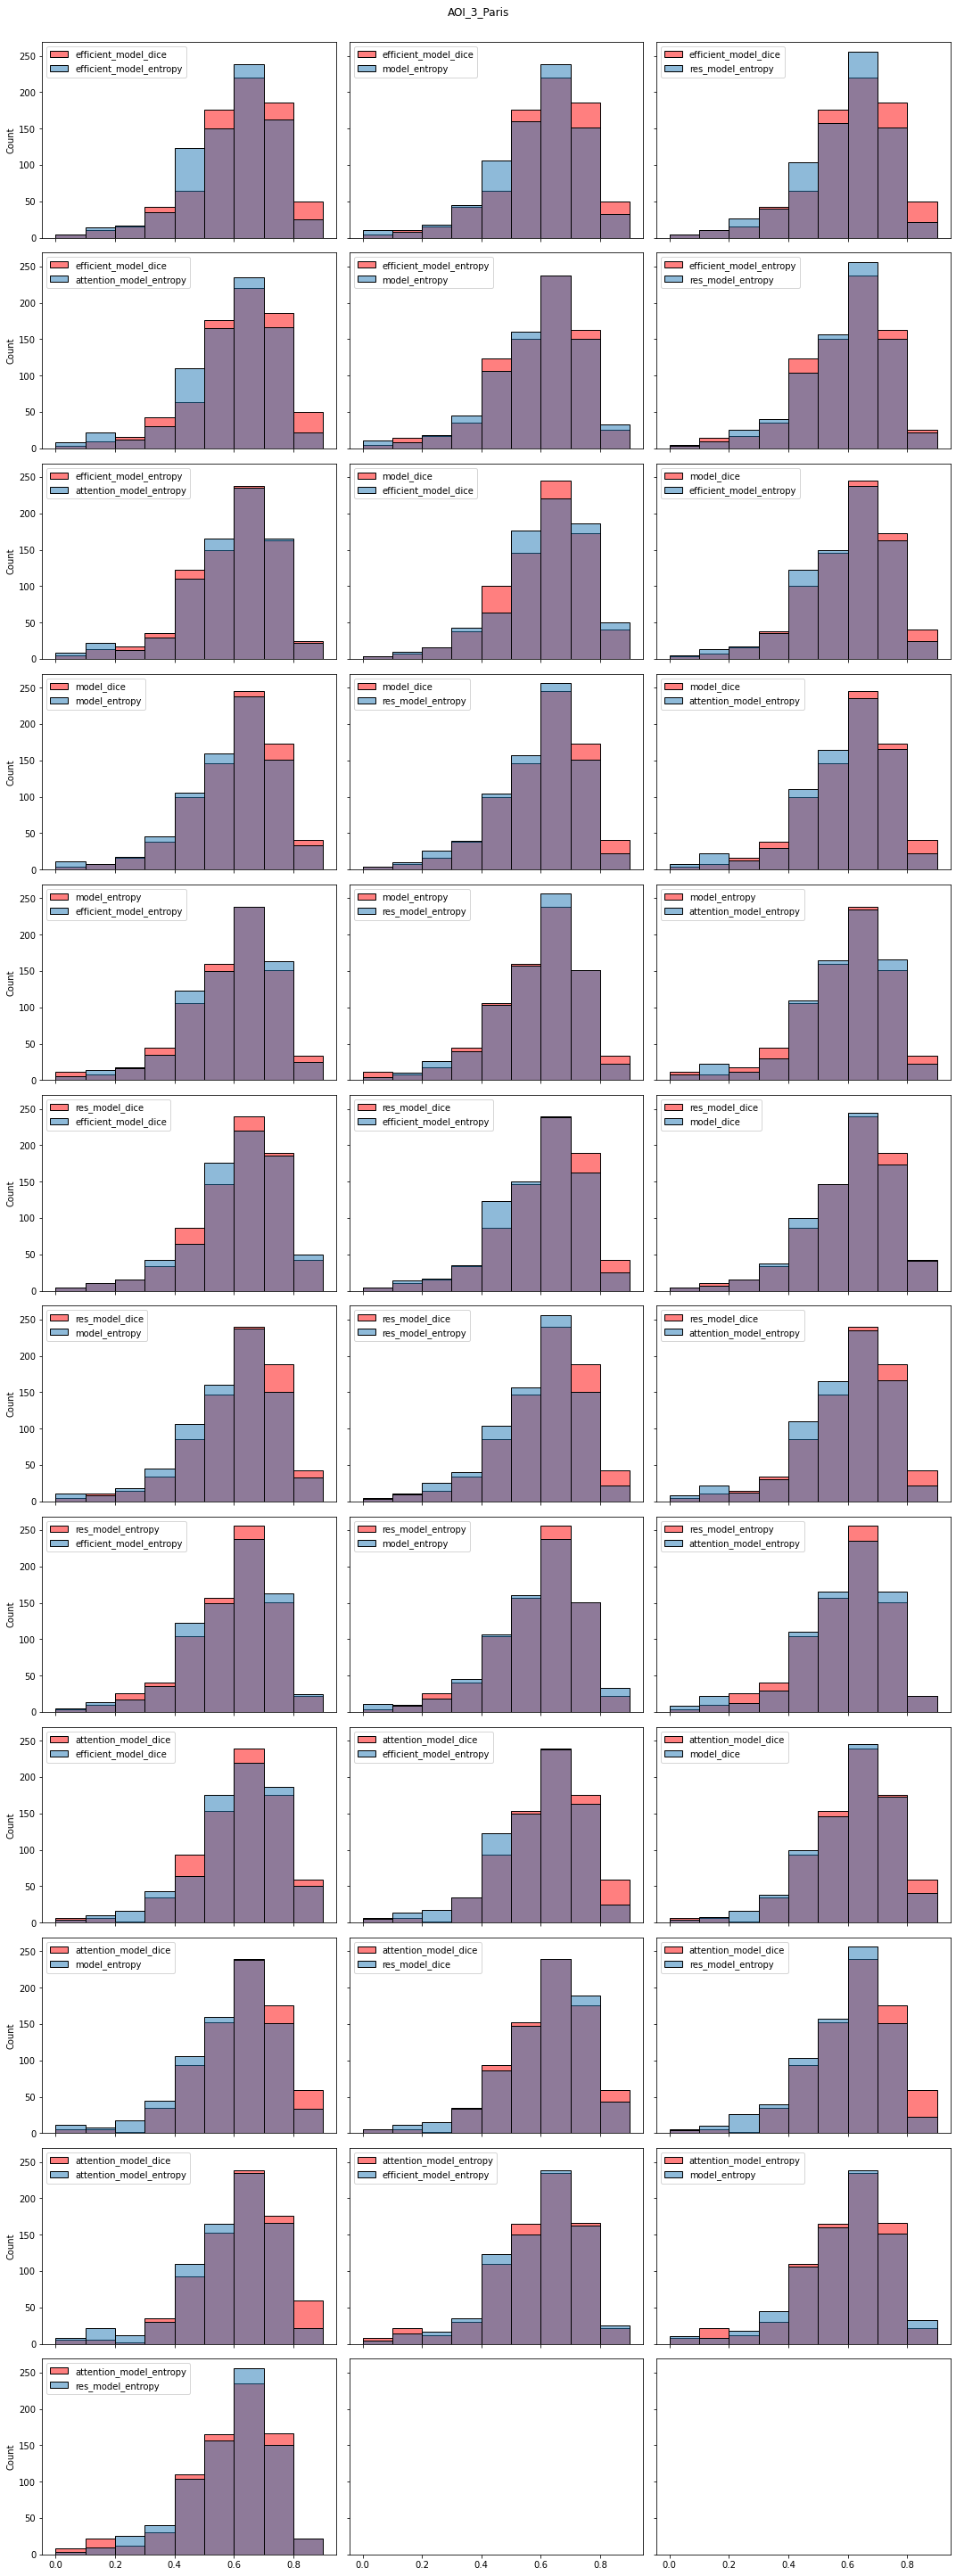

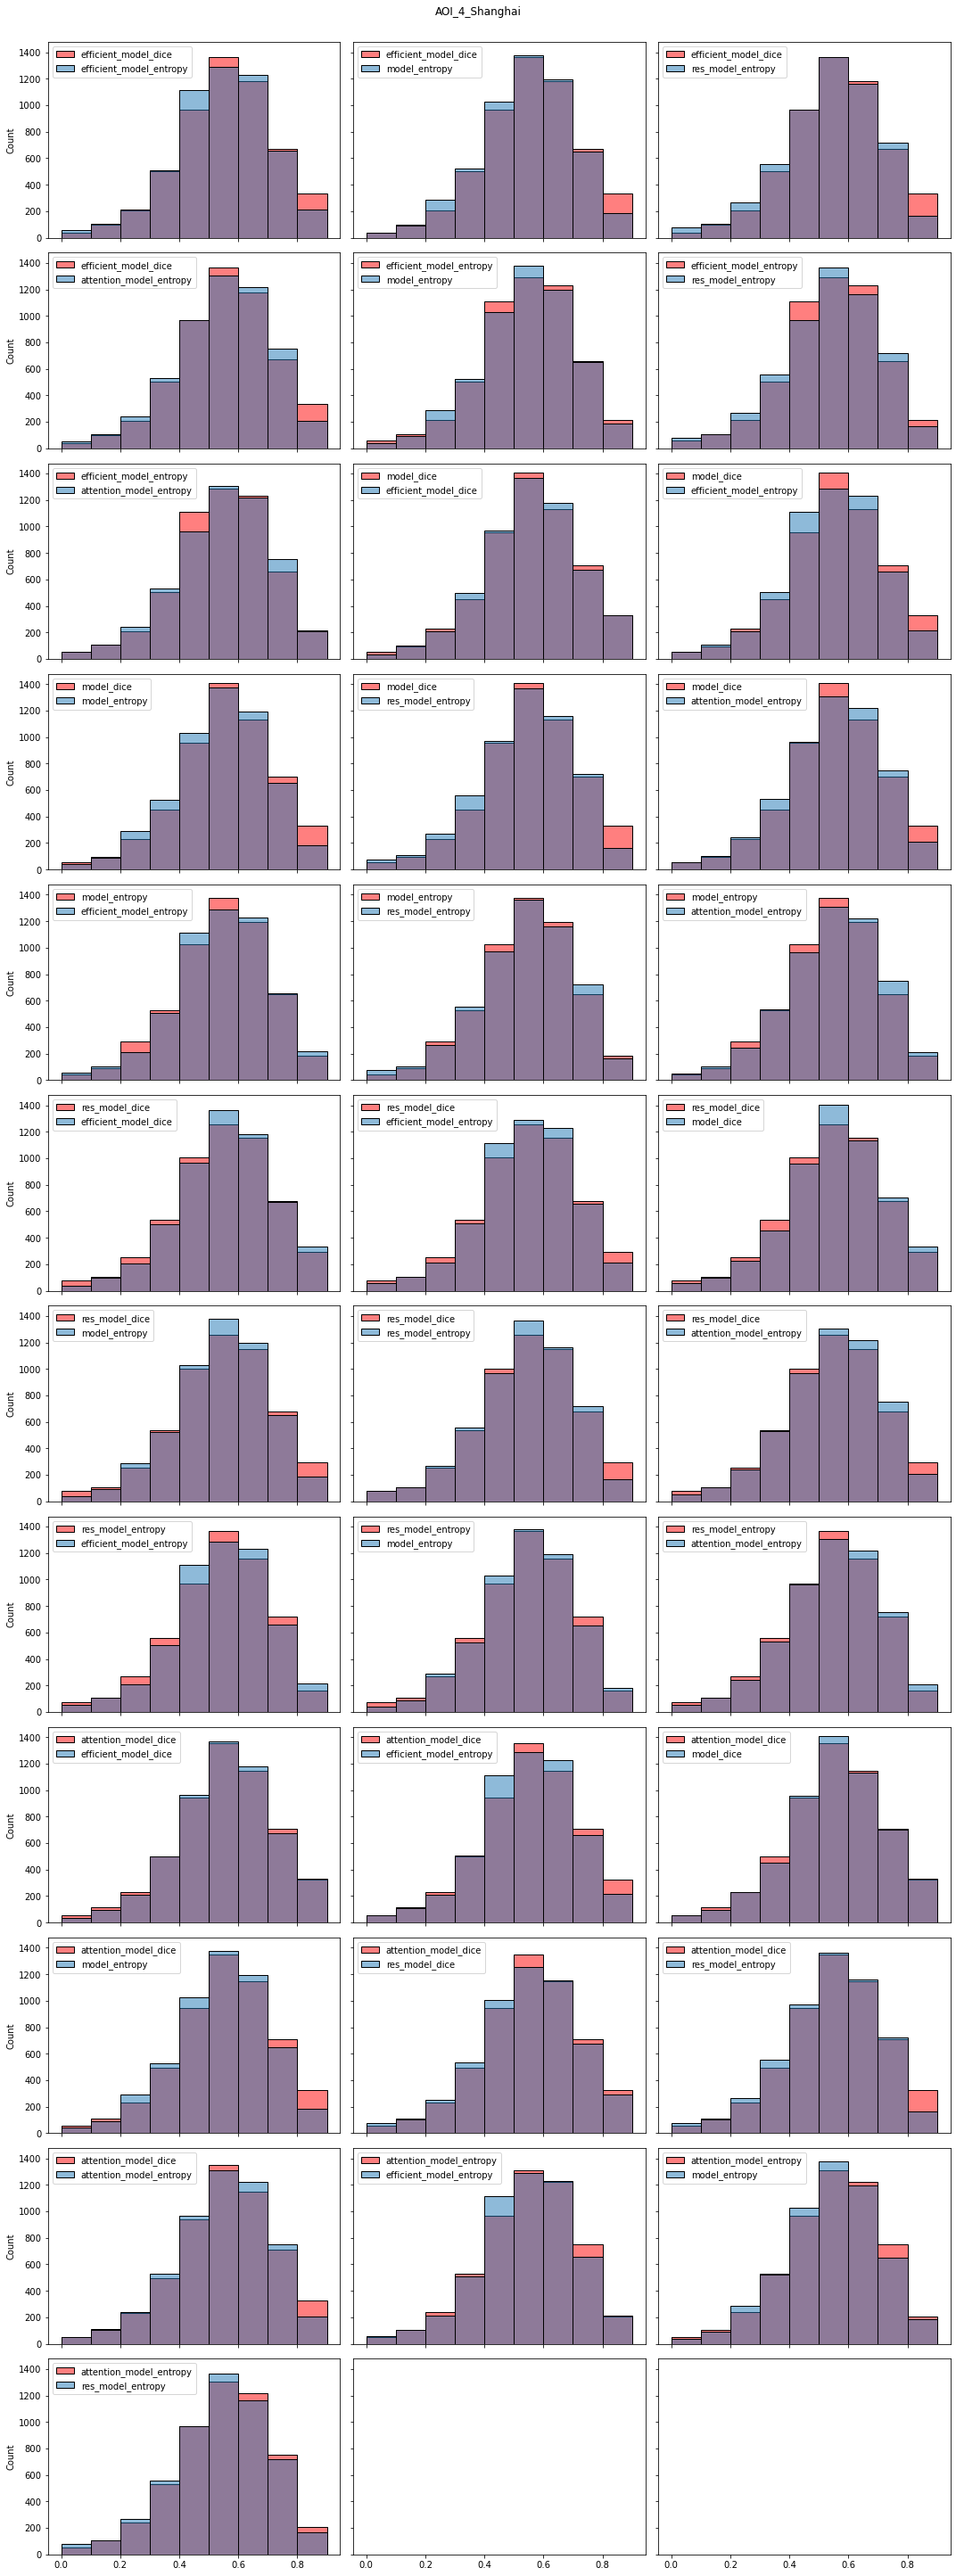

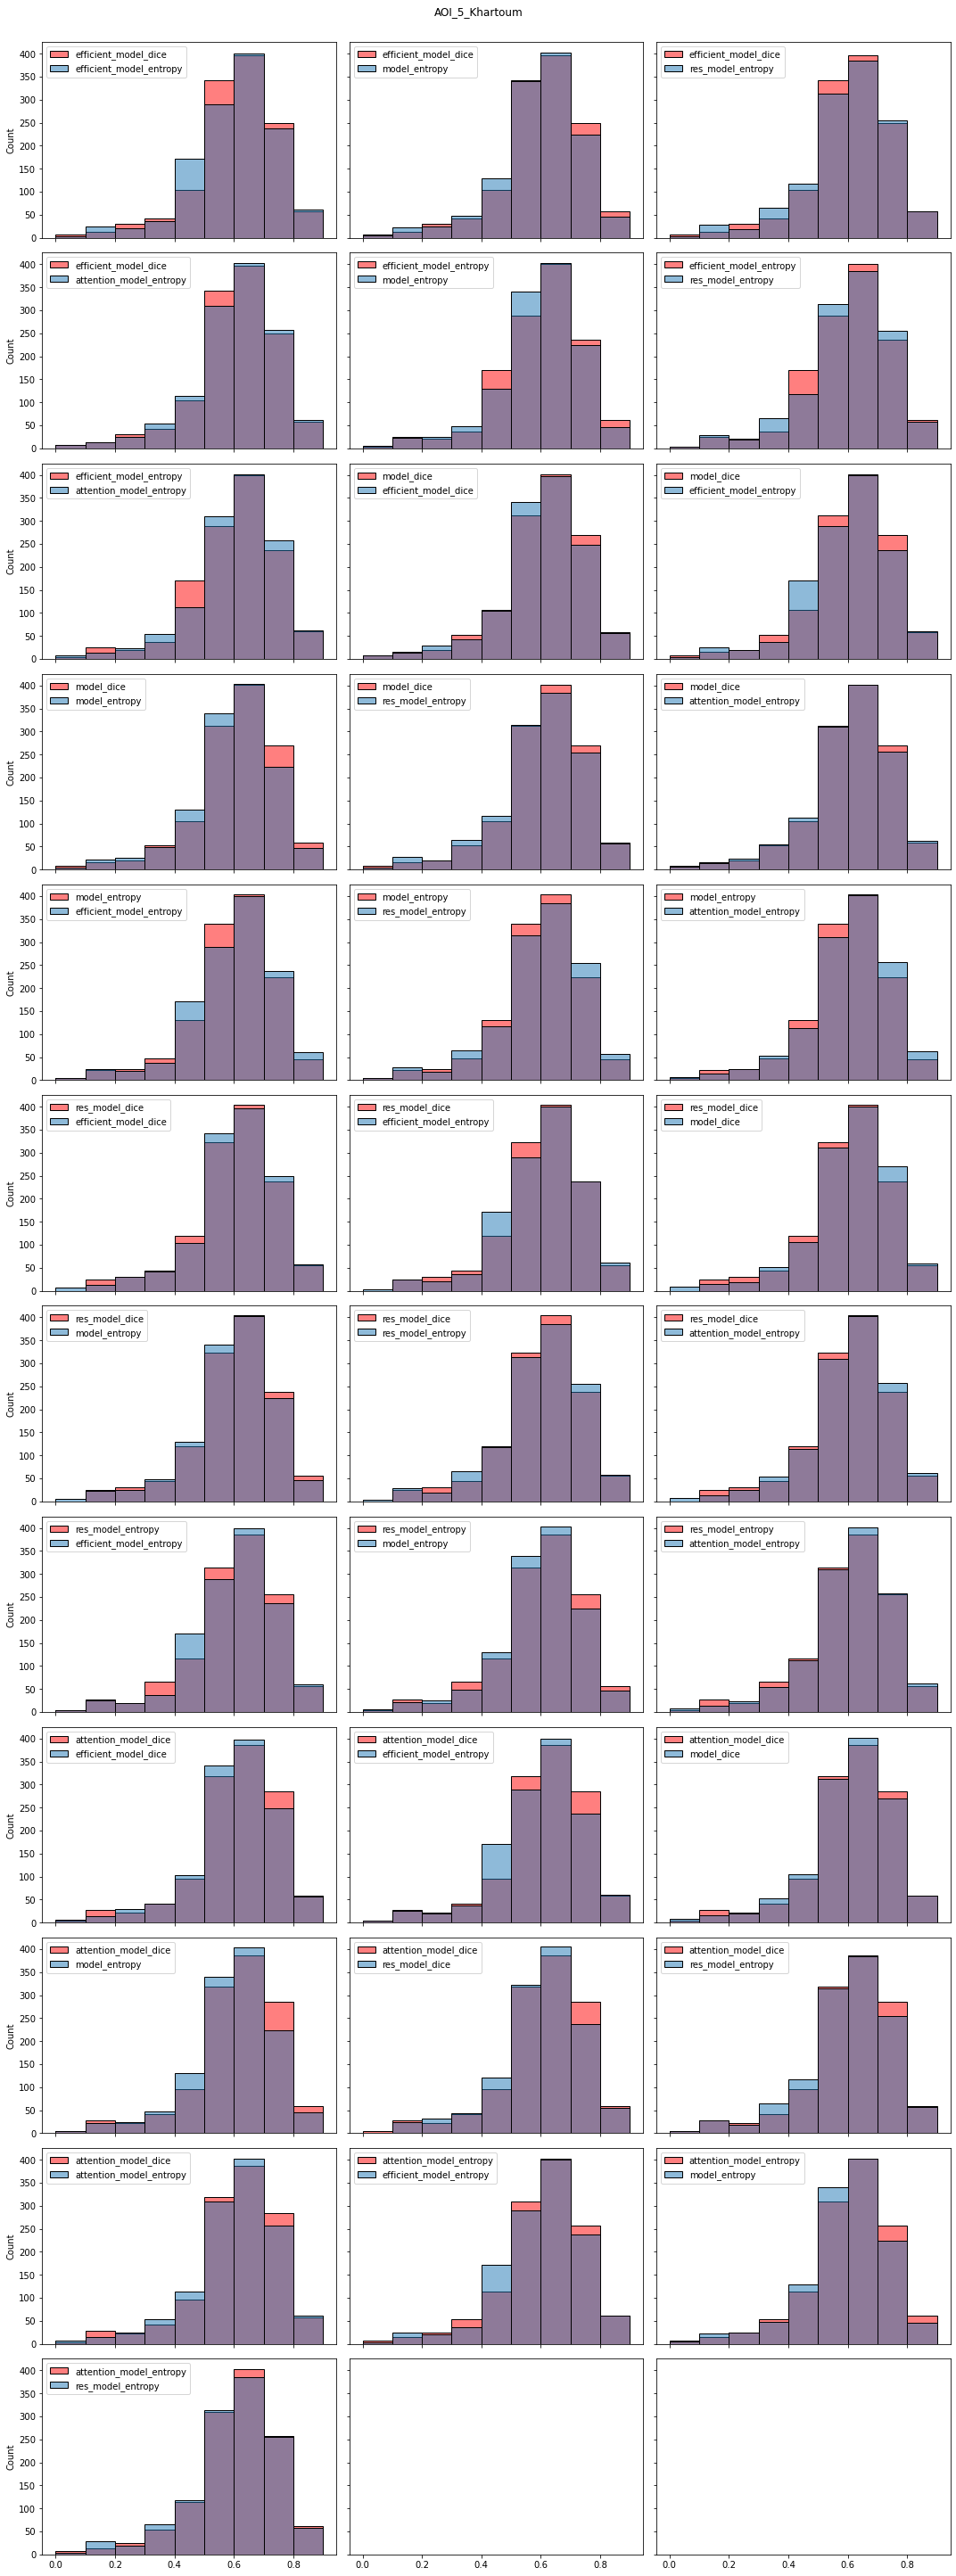

In [24]:
p_values_dict = {}
for area in areas_of_interest:
    p_values_dict[area] = pd.DataFrame(index=models, columns=models)
    for m1, m2 in pairs:
        if m1 != m2:
            if (np.mean(model_metrics[m1]['road_iou'][area]) > np.mean(model_metrics[m2]['road_iou'][area])):
                _, p_val = stats.ttest_ind(model_metrics[m1]['road_iou'][area], model_metrics[m2]['road_iou'][area], alternative ='greater')
                p_values_dict[area].loc[m2, m1] = p_val
            else:
                _, p_val = stats.ttest_ind(model_metrics[m2]['road_iou'][area], model_metrics[m1]['road_iou'][area], alternative ='greater')
                p_values_dict[area].loc[m1, m2] = p_val

Below we present a table of p-values testing if the models in the rows have a greater IoU than the models in the columns on average. This is limited to comparing roads. We only compare the cases where the mean IoU of one model is measured to be greater than another. If p-value is less than 0.05 this is what we can conclude this to be statistically significant.

In [25]:
for key in p_values_dict.keys():
    print(key)
    display(p_values_dict[key])

AOI_2_Vegas


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,0.236835,0.074902
efficient_model_entropy,0.1417,NaN,0.175361,NaN,0.304693,NaN,0.035599,0.005728
model_dice,0.440019,NaN,NaN,NaN,NaN,NaN,0.190187,0.053855
model_entropy,0.130681,0.479491,0.16248,NaN,0.287075,NaN,0.031818,0.004964
res_model_dice,0.286898,NaN,0.338196,NaN,NaN,NaN,0.098999,0.022124
res_model_entropy,0.066649,0.329116,0.085672,0.347825,0.171835,NaN,0.012906,0.001619
attention_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.231683
attention_model_entropy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


AOI_3_Paris


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,NaN,NaN,NaN,0.4582,NaN,0.161681,NaN
efficient_model_entropy,0.001766,NaN,0.012082,NaN,0.001213,NaN,0.000032,NaN
model_dice,0.230963,NaN,NaN,NaN,0.19878,NaN,0.038085,NaN
model_entropy,0.000782,0.379644,0.00589,NaN,0.000527,0.385088,0.000012,0.451299
res_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,0.188612,NaN
res_model_entropy,0.001512,0.49292,0.010795,NaN,0.001028,NaN,0.000025,NaN
attention_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attention_model_entropy,0.001115,0.42722,0.008026,NaN,0.000758,0.433349,0.000019,NaN


AOI_4_Shanghai


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
efficient_model_entropy,0.000004,NaN,0.00002,NaN,0.146554,NaN,0.000373,0.092599
model_dice,0.379932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_entropy,0.0,0.163514,0.0,NaN,0.022962,NaN,0.000007,0.010682
res_model_dice,0.000595,NaN,0.001717,NaN,NaN,NaN,0.013242,0.408942
res_model_entropy,0.0,0.03612,0.0,0.201696,0.002819,NaN,0.0,0.000993
attention_model_dice,0.15429,NaN,0.23893,NaN,NaN,NaN,NaN,NaN
attention_model_entropy,0.000942,NaN,0.002695,NaN,NaN,NaN,0.019981,NaN


AOI_5_Khartoum


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,NaN,0.232167,NaN,NaN,NaN,0.184511,0.471193
efficient_model_entropy,0.143261,NaN,0.037302,NaN,0.257844,NaN,0.026482,0.129574
model_dice,NaN,NaN,NaN,NaN,NaN,NaN,0.430727,NaN
model_entropy,0.037607,0.243115,0.006243,NaN,0.087129,0.282012,0.00411,0.033159
res_model_dice,0.337662,NaN,0.12572,NaN,NaN,NaN,0.095414,0.312968
res_model_entropy,0.121446,0.455581,0.030251,NaN,0.224801,NaN,0.021329,0.109527
attention_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attention_model_entropy,NaN,NaN,0.256653,NaN,NaN,NaN,0.206135,NaN


### Buildings
We now perform the same analysis as above as we did for the extracted roads, but for extracted buildings:

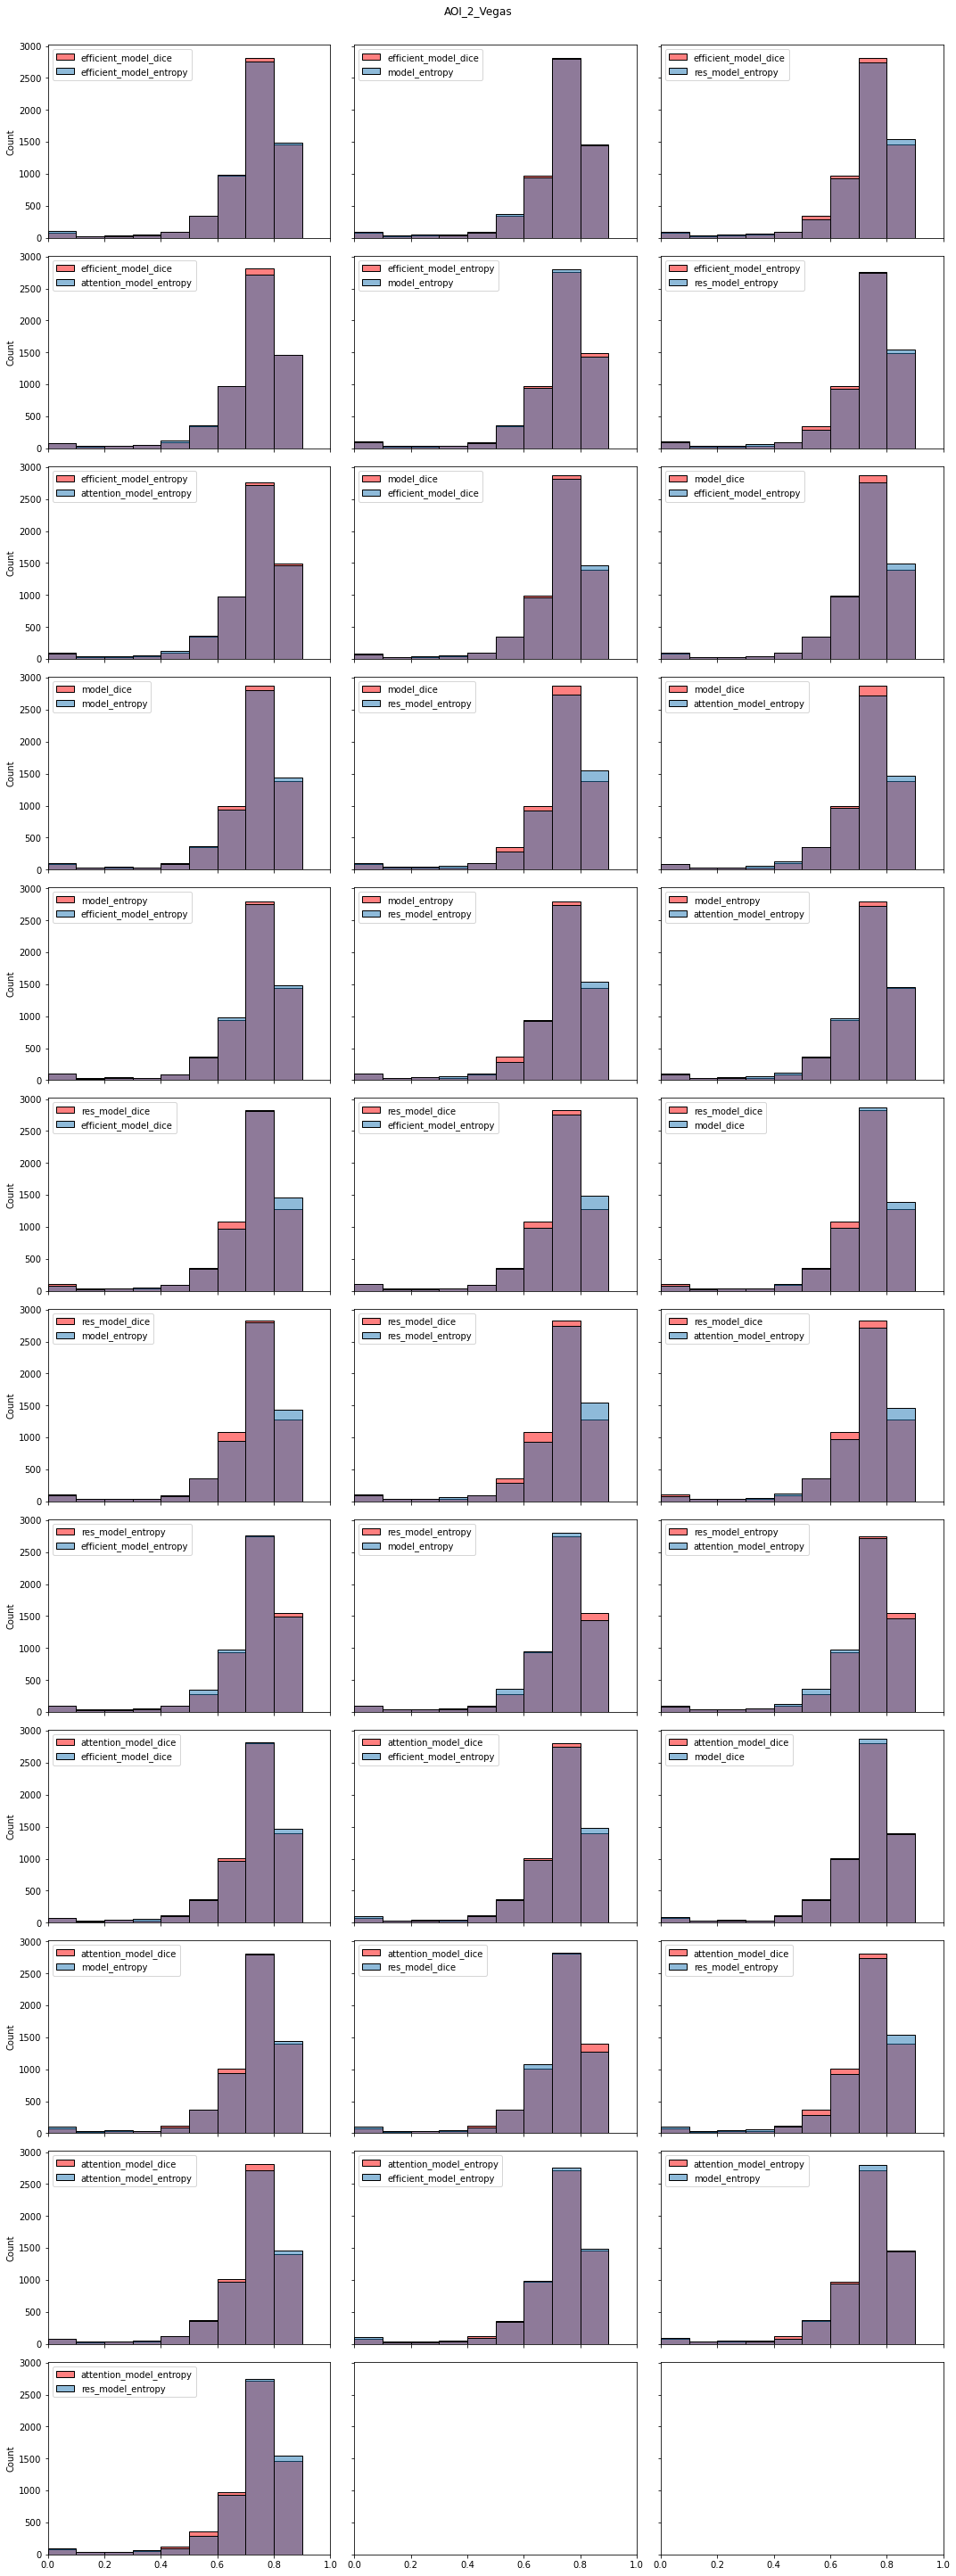

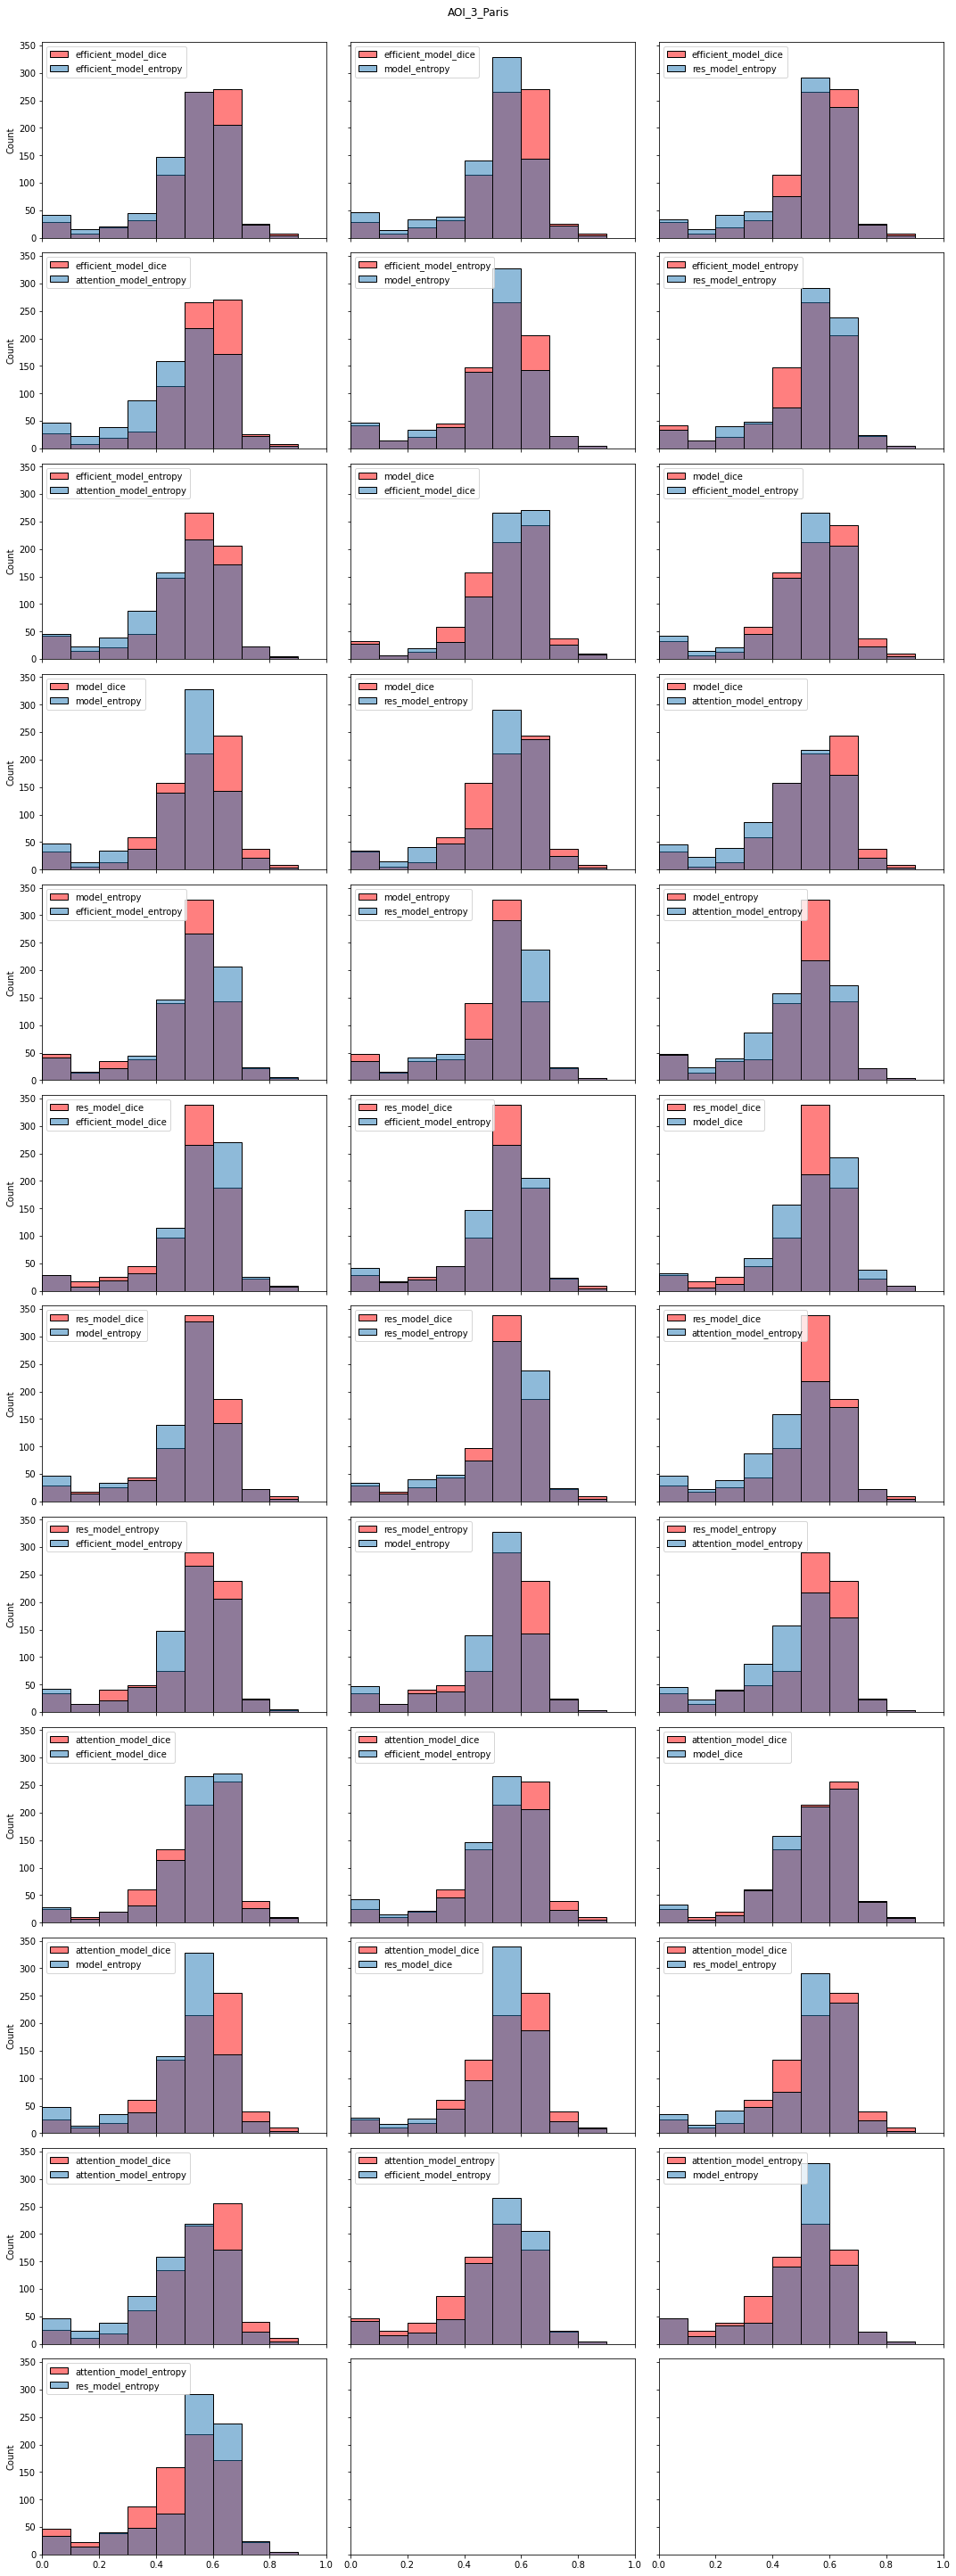

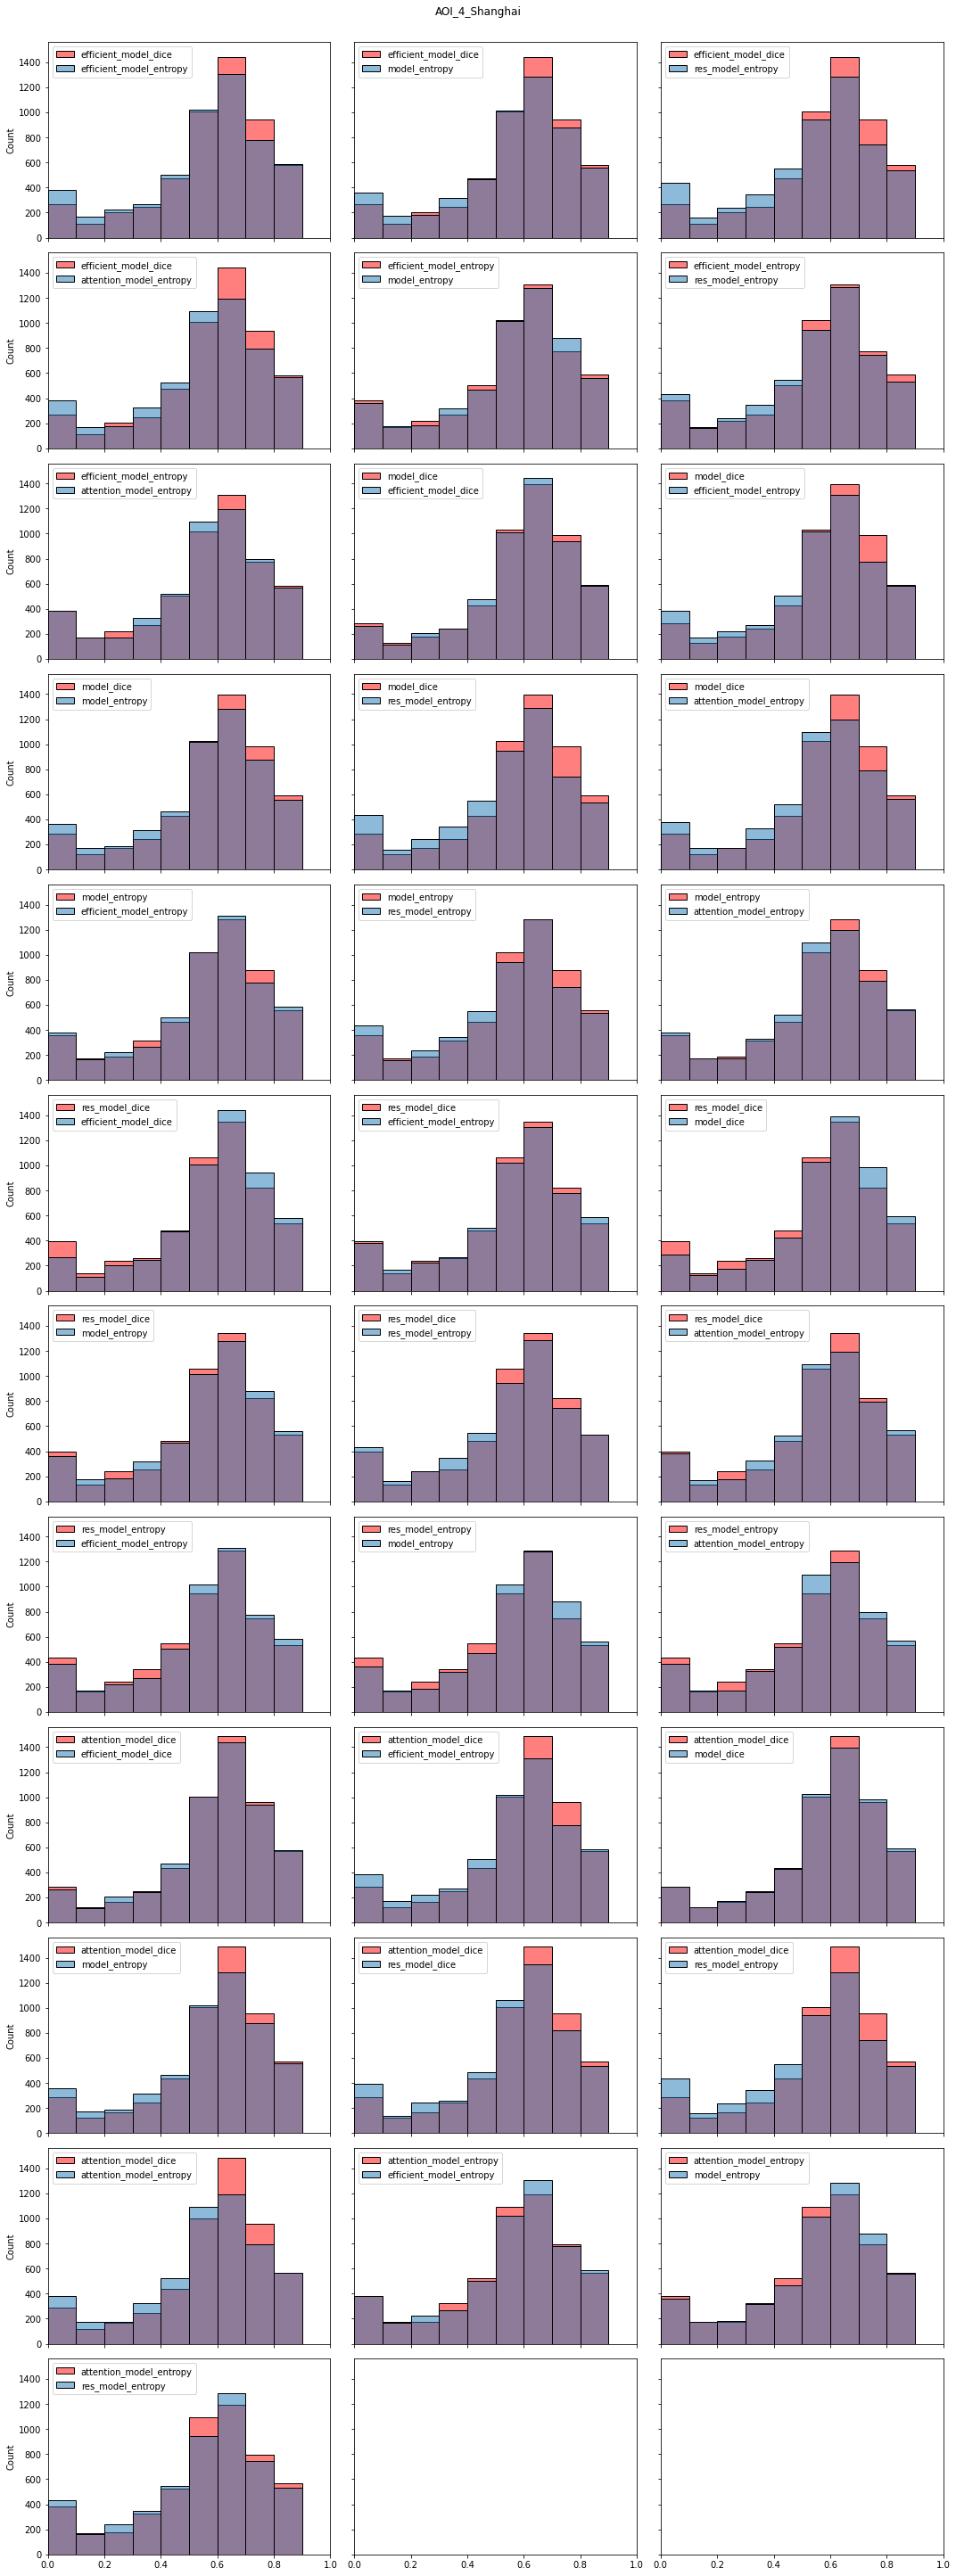

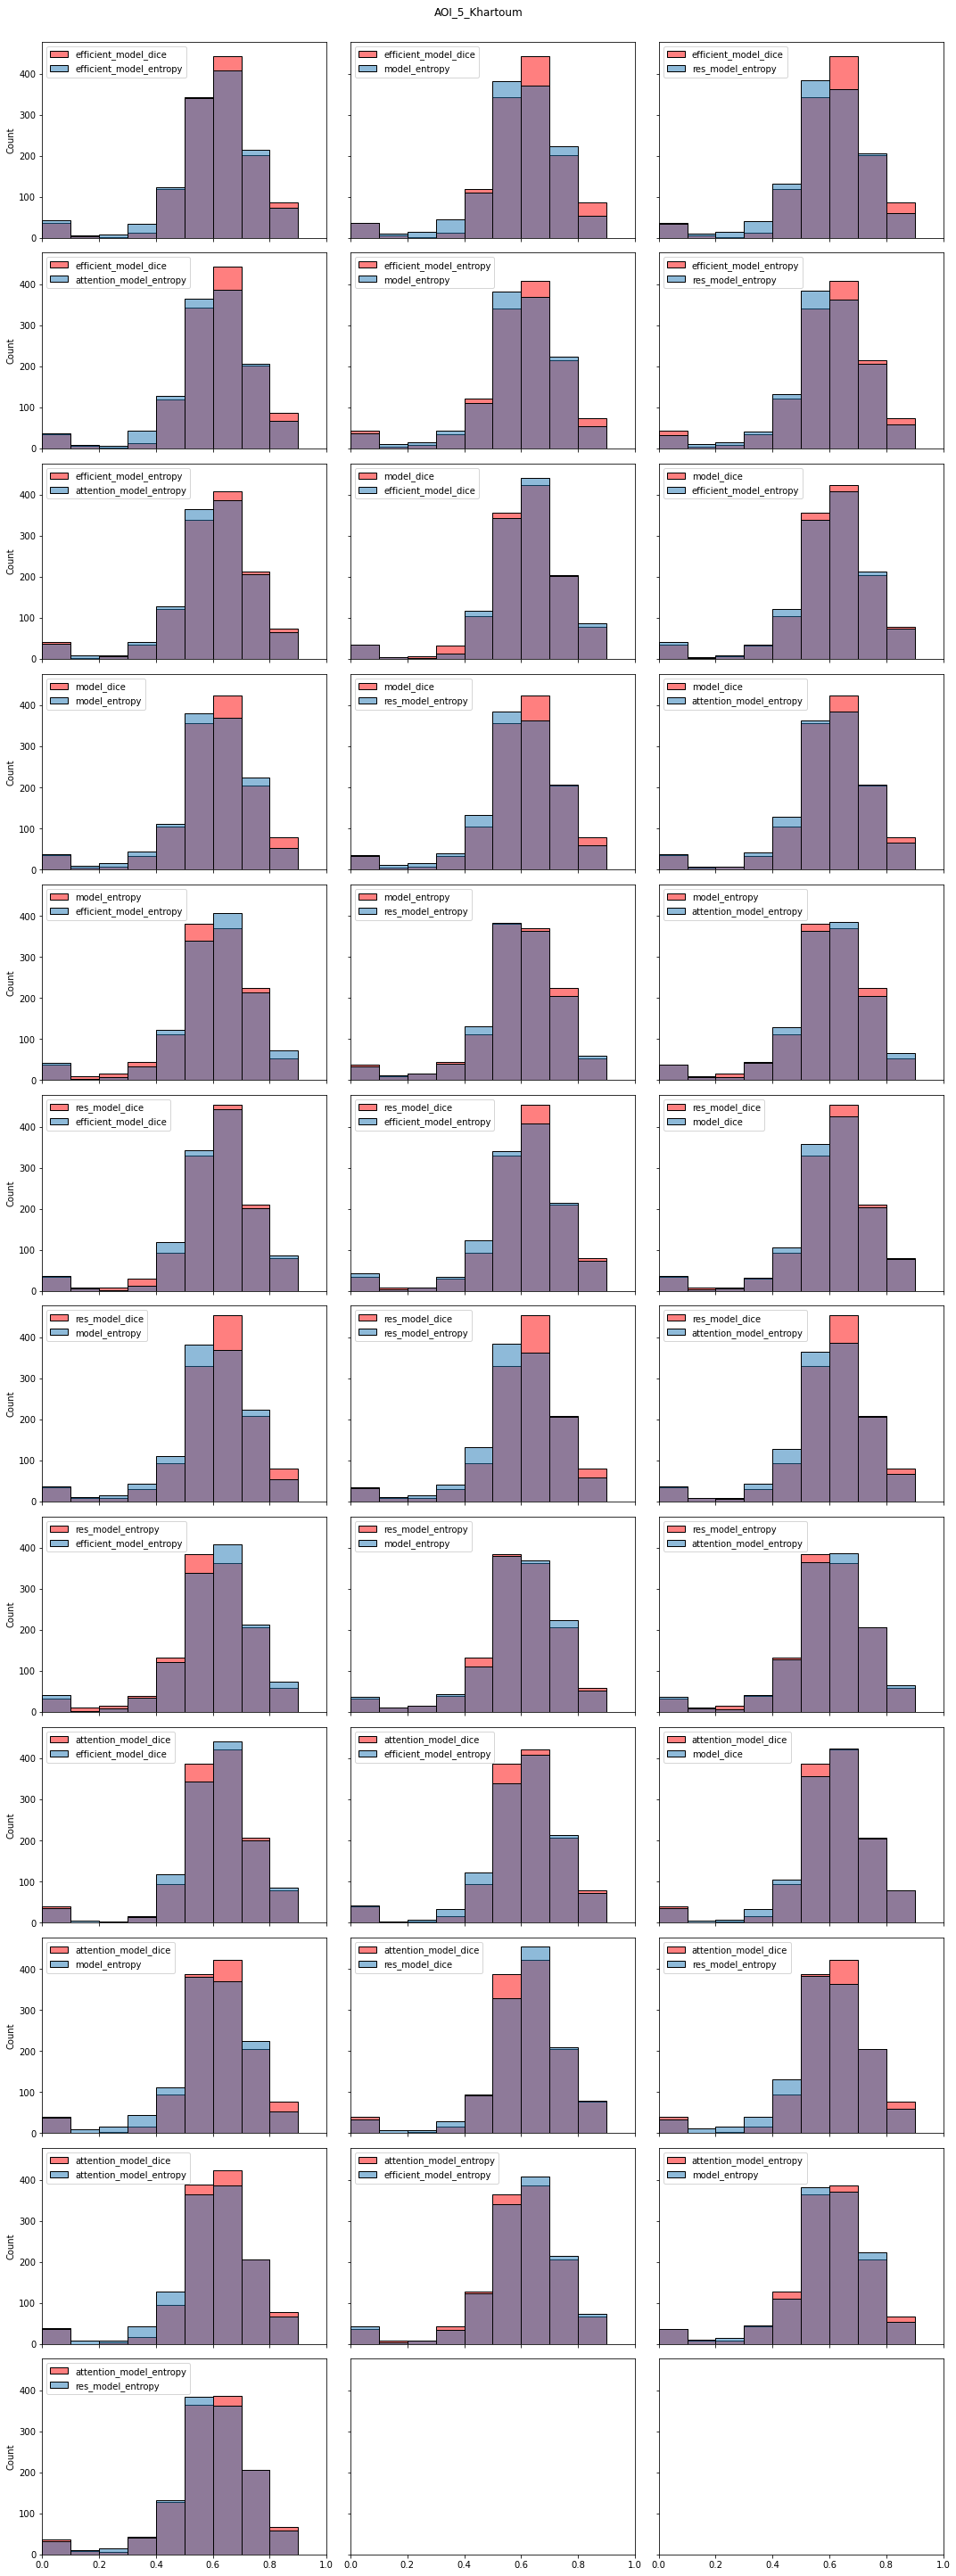

In [31]:
p_values_dict = {}
for area in areas_of_interest:
    p_values_dict[area] = pd.DataFrame(index=models, columns=models)
    for m1, m2 in pairs:
        if m1 != m2:
            if (np.mean(model_metrics[m1]['building_iou'][area]) > np.mean(model_metrics[m2]['building_iou'][area])):
                _, p_val = stats.ttest_ind(model_metrics[m1]['building_iou'][area], model_metrics[m2]['building_iou'][area], alternative ='greater')
                p_values_dict[area].loc[m1, m2] = p_val
            else:
                _, p_val = stats.ttest_ind(model_metrics[m2]['building_iou'][area], model_metrics[m1]['building_iou'][area], alternative ='greater')
                p_values_dict[area].loc[m2, m1] = p_val

In [32]:
for key in p_values_dict.keys():
    print(key)
    display(p_values_dict[key])

AOI_2_Vegas


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,0.347111,0.273969,0.231438,0.000601,0.454334,0.306271,0.139344
efficient_model_entropy,NaN,NaN,0.423585,0.369177,0.002742,NaN,0.460535,0.250513
model_dice,NaN,NaN,NaN,0.44043,0.004026,NaN,NaN,0.309947
model_entropy,NaN,NaN,NaN,NaN,0.007458,NaN,NaN,0.368316
res_model_dice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
res_model_entropy,NaN,0.395334,0.322346,0.276451,0.001352,NaN,0.355664,0.176705
attention_model_dice,NaN,NaN,0.461446,0.403404,0.002939,NaN,NaN,0.276771
attention_model_entropy,NaN,NaN,NaN,NaN,0.017542,NaN,NaN,NaN


AOI_3_Paris


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,0.000056,0.095994,0.0,0.00553,0.004609,0.206522,0.0
efficient_model_entropy,NaN,NaN,NaN,0.052582,NaN,NaN,NaN,0.000345
model_dice,NaN,0.006086,NaN,0.000015,0.119031,0.100226,NaN,0.0
model_entropy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032606
res_model_dice,NaN,0.08377,NaN,0.001109,NaN,0.446809,NaN,0.000001
res_model_entropy,NaN,0.112194,NaN,0.002191,NaN,NaN,NaN,0.000002
attention_model_dice,NaN,0.001275,0.312616,0.000001,0.045473,0.037743,NaN,0.0
attention_model_entropy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


AOI_4_Shanghai


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,0.0,NaN,0.000003,0.0,0.0,NaN,0.0
efficient_model_entropy,NaN,NaN,NaN,NaN,0.355986,0.001675,NaN,0.426952
model_dice,0.241126,0.0,NaN,0.0,0.0,0.0,0.335868,0.0
model_entropy,NaN,0.132333,NaN,NaN,0.067547,0.000026,NaN,0.096405
res_model_dice,NaN,NaN,NaN,NaN,NaN,0.004819,NaN,NaN
res_model_entropy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attention_model_dice,0.390581,0.0,NaN,0.000001,0.0,0.0,NaN,0.0
attention_model_entropy,NaN,NaN,NaN,NaN,0.426852,0.002923,NaN,NaN


AOI_5_Khartoum


,efficient_model_dice,efficient_model_entropy,model_dice,model_entropy,res_model_dice,res_model_entropy,attention_model_dice,attention_model_entropy
efficient_model_dice,NaN,0.051277,0.413059,0.00079,0.498065,0.000849,NaN,0.010129
efficient_model_entropy,NaN,NaN,NaN,0.071174,NaN,0.073571,NaN,0.259791
model_dice,NaN,0.080301,NaN,0.001794,NaN,0.001915,NaN,0.018712
model_entropy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
res_model_dice,NaN,0.054068,0.416101,0.000925,NaN,0.000992,NaN,0.011135
res_model_entropy,NaN,NaN,NaN,0.49399,NaN,NaN,NaN,NaN
attention_model_dice,0.392537,0.029385,0.312612,0.000321,0.392138,0.000347,NaN,0.004943
attention_model_entropy,NaN,NaN,NaN,0.20085,NaN,0.205541,NaN,NaN


While the above results are useful, they are over whelming. Also, many of the comparisons do not have statistical significance. 
## Comparison of IoU between models
Next we combine the areas of interest into one set of samples, this simplifies the results so that we can just focus on analyzing the IoU differences between the models. This is marginalizing over the areas of interest and categories of building and roads.

Below we plot the IoU histograms side by side for each of the models, and report their mean and standard deviation:

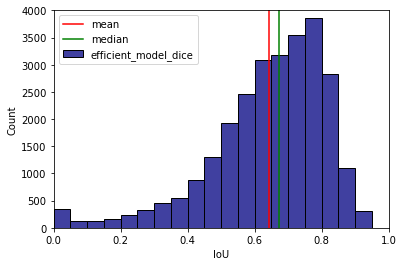

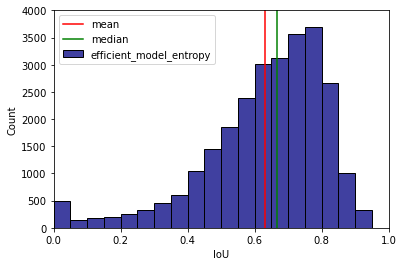

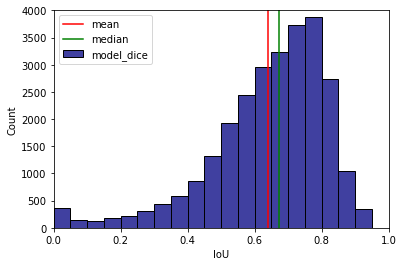

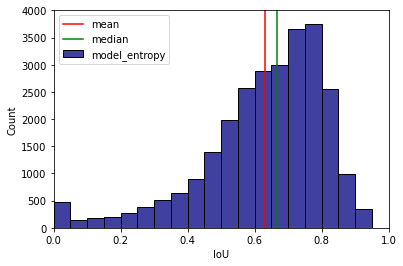

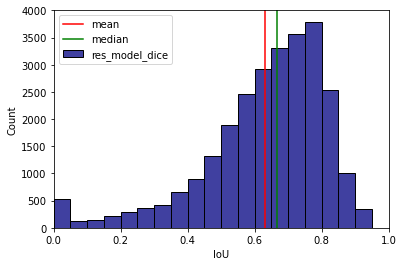

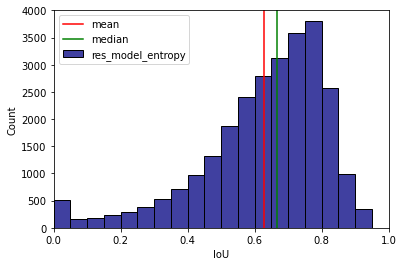

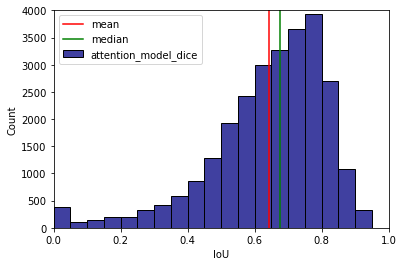

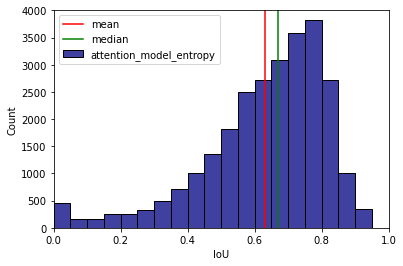

,Mean IoU,Median IoU
efficient_model_dice,0.641711,0.672676
attention_model_dice,0.64171,0.674638
model_dice,0.641358,0.673901
attention_model_entropy,0.631864,0.670037
res_model_dice,0.631678,0.668066
efficient_model_entropy,0.631089,0.665989
model_entropy,0.630185,0.665969
res_model_entropy,0.627082,0.666235


In [47]:
combined_data = {}
stats = pd.DataFrame(index=models, columns=['Mean IoU','Median IoU'])
for area in areas_of_interest:
    for m1 in models:
        if m1 not in combined_data.keys():
             combined_data[m1]= []
        combined_data[m1] += model_metrics[m1]['road_iou'][area] + model_metrics[m1]['building_iou'][area]
for m1 in models:
    sns.histplot(x=combined_data[m1], bins=np.arange(0, 1, 0.05), label=f'{m1}', color='navy', legend=m1)
    plt.xlim([0,1])
    plt.ylim([0, 4000])
    plt.axvline(np.mean(combined_data[m1]), label='mean', c ='red')
    plt.axvline(np.median(combined_data[m1]), label='median', c='green')
    plt.xlabel("IoU")
    plt.legend()
    plt.show()
    stats.loc[m1, 'Mean IoU'] =  np.mean(combined_data[m1])
    stats.loc[m1, 'Median IoU'] = np.median(combined_data[m1])
stats.sort_values('Mean IoU', ascending=False, inplace=True)
stats

Above you can see the differences appear quite small, and it is difficult to compare by eyes. However, if you pay attention, you will notice that models using the cross entropy have a lower mean and median than models using the dice loss.


Now we do a pair-wise t-test, we then plot the p-values. 

We mask the p-values where the mean in the model for the columns is less or equal to the mean for the model in the rows.

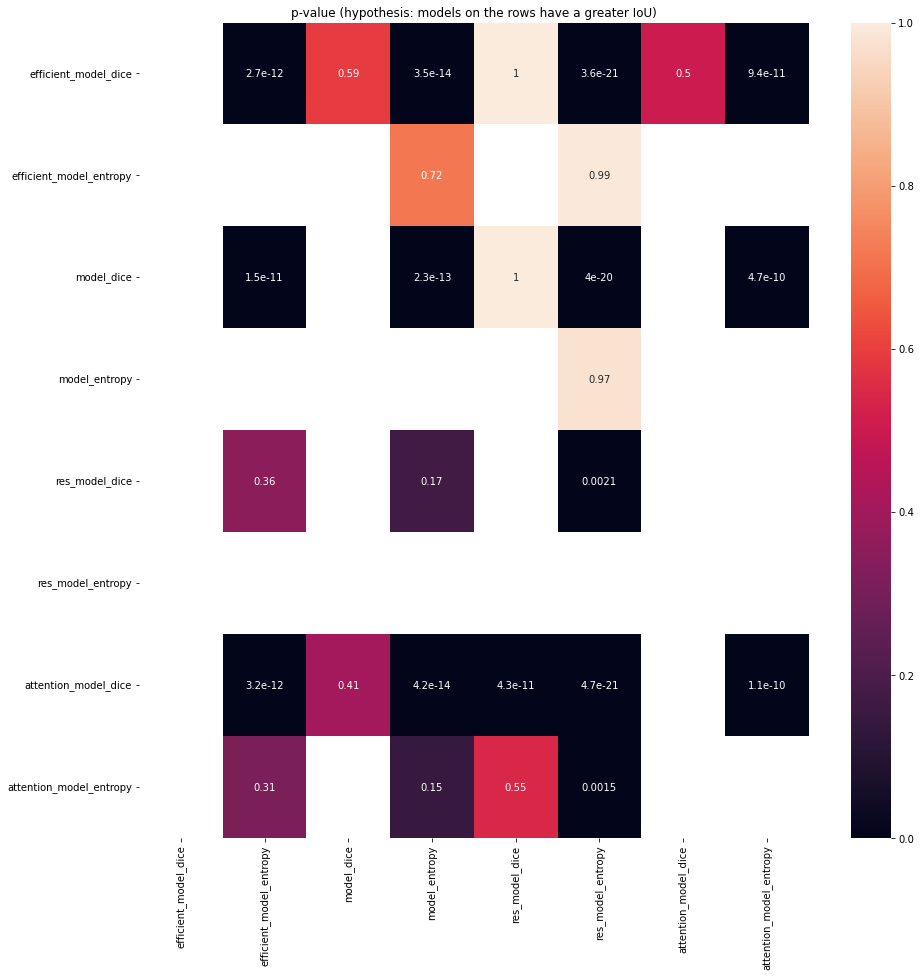

In [39]:
p_values = pd.DataFrame(index=models, columns=models, dtype=float)  

for m1, m2 in pairs:
    if m1 != m2:
        if np.mean(combined_data[m1]) > np.mean(combined_data[m2]):
            _, p_val = stats.ttest_ind(combined_data[m1], combined_data[m2], alternative ='greater')
            p_values.loc[m1, m2] = p_val
            p_values.loc[m2, m1] = np.nan
        else:
            _, p_val = stats.ttest_ind(combined_data[m1], combined_data[m2], alternative ='greater')
            p_values.loc[m2, m1] = p_val
            p_values.loc[m1, m2] = np.nan
plt.figure(figsize=(15, 15))
plt.title('p-value (hypothesis: models on the rows have a greater IoU)')
sns.heatmap(p_values, mask = np.isnan(p_values), annot=True)
plt.show()

While this is insightful, it doesn't account for the fact that we are doing multiple pair-wise t-tests tests. When doing multiple pair-wise p-value comparisons, we need to correct for the false discovery rate.
There is still quite a lot of complexity in plotting this matrix.

## Tukey HSD
To fix both the issue of false discovery rate and complexity, we use the Tukey HSD pair-wise test:

In [14]:
from statsmodels.stats.multicomp import MultiComparison
input_data = []
input_group = []
for k in combined_data.keys():
    input_data += list(combined_data[k])
    input_group += [k for l in range(len(combined_data[k]))]
comp = MultiComparison(input_data, input_group)
tukey_hsd_results = comp.tukeyhsd()

There are two Major outputs from the Tukey HSD:
1. The first is a plot of the mean IoU score with associated error bars for each model, when the error bras don't overlap we can say there is a significant difference between two models.
2. The below plots are much simpler. There are three plots that are identical in data, but showing how model_dice, efficient_model_dice, and attention_model_dice have a statistically significant larger IoU on average than the other models.

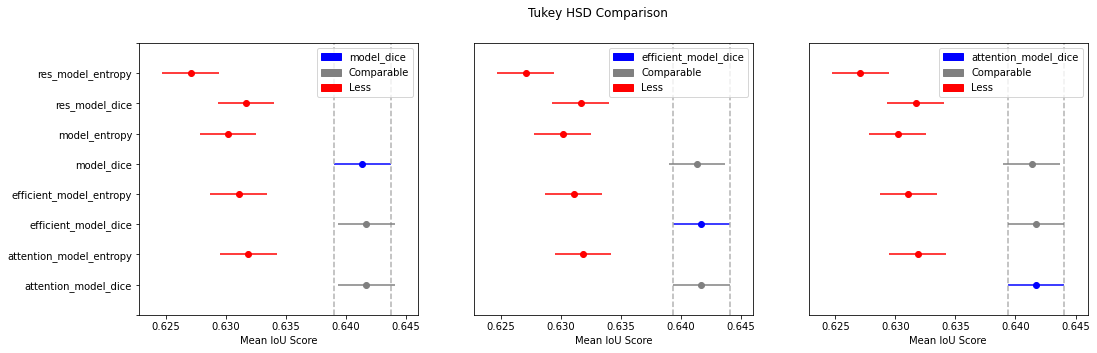

In [25]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(1,3)
tukey_hsd_results.plot_simultaneous(comparison_name='model_dice', ax=ax[0], xlabel='Mean IoU Score')
tukey_hsd_results.plot_simultaneous(comparison_name='efficient_model_dice', ax=ax[1], xlabel='Mean IoU Score')
tukey_hsd_results.plot_simultaneous(comparison_name='attention_model_dice', ax=ax[2], xlabel='Mean IoU Score', figsize=(17, 5))
ax[0].set_title('')
ax[1].set_title('')
ax[2].set_title('')
fig.suptitle("Tukey HSD Comparison")
ax[0].legend(handles=[Patch(facecolor='blue', edgecolor='blue',
                         label='model_dice'), Patch(facecolor='grey', edgecolor='grey',
                         label='Comparable'), Patch(facecolor='red', edgecolor='red',
                         label='Less')], loc="upper right")
ax[1].legend(handles=[Patch(facecolor='blue', edgecolor='blue',
                         label='efficient_model_dice'), Patch(facecolor='grey', edgecolor='grey',
                         label='Comparable'), Patch(facecolor='red', edgecolor='red',
                         label='Less')], loc="upper right")
ax[2].legend(handles=[Patch(facecolor='blue', edgecolor='blue',
                         label='attention_model_dice'), Patch(facecolor='grey', edgecolor='grey',
                         label='Comparable'), Patch(facecolor='red', edgecolor='red',
                         label='Less')], loc="upper right")
ax[1].axes.get_yaxis().set_visible(False)
ax[2].axes.get_yaxis().set_visible(False)
plt.show()

What we are seeing that the dice loss performs better than the categorical cross-entropy for providing a higher IoU on average per an image, unless using a residual UNet model with a dice loss.

The dice loss has a similar form to the IoU metric, this might be why it appears to perform better. For example, minimizing the dice loss might lead to a larger IoU by construction.
One issue with the binary cross-entropy, is that the categories are not balanced. Most of the pixels in an image will not be a building or a road. This makes metrics, such as accuracy not reliable.

The same results that are displayed above are shown in the table below, where we can see if we can reject the null-hypothesis that two means are the same.

In [26]:
tukey_hsd_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
attention_model_dice,attention_model_entropy,-0.0098,0.0,-0.0146,-0.0051,True
attention_model_dice,efficient_model_dice,0.0,1.0,-0.0047,0.0047,False
attention_model_dice,efficient_model_entropy,-0.0106,0.0,-0.0153,-0.0059,True
attention_model_dice,model_dice,-0.0004,1.0,-0.0051,0.0044,False
attention_model_dice,model_entropy,-0.0115,0.0,-0.0163,-0.0068,True
attention_model_dice,res_model_dice,-0.01,0.0,-0.0148,-0.0053,True
attention_model_dice,res_model_entropy,-0.0146,0.0,-0.0194,-0.0099,True
attention_model_entropy,efficient_model_dice,0.0098,0.0,0.0051,0.0146,True
attention_model_entropy,efficient_model_entropy,-0.0008,0.9997,-0.0055,0.004,False
attention_model_entropy,model_dice,0.0095,0.0,0.0048,0.0142,True


# Conclusions
We set out to compare different convolutional neural networks, and find out if we can get reasonable results.
1. We cleaned, combined, and processed two different datasets. 
2. These datasets were then used to train convolutional neural networks to simultaneously extract buildings and road networks, through a process known as semantic segmentation. 
3. We used a UNet architecture, which has an encoder and decoder component with connections between the encoder and decoder layers.
4. We compared 8 different models, the UNet, EfficientNet UNet, Attention-UNet, and Residual UNet models trained on two different loss functions.
5. I found that the results improved when completely removed images that were missing either building or road labels, e.g., using partial label data is not a good idea! (but it was worth a try.)
6. To compare the models we used the Intersection over Union (IoU) score which ranges between 0 to 1. It is a measure of how much the true and predicted feature extractions overlap.
7. The IoU scores on median and average were greater than 0.62 on the test set. This means on average 38% of the structures do not overlap with the ground truth.
8. A Tukey HSD test was used to find the best models: UNet, EfficientNet UNet, Attention-UNet using the dice loss performed better on average.

# Discussion and Remarks
There are many things that can still be explored and might improve the results in training these models. 
- Making use of stacking with the UNet models or some type of aggregation of an ensemble of models might help improve the result, this was shown to perform well in competitions. However, due to limited time it was not possible to train an ensemble of models.
- It could be worth trying an ensemble method in the cloud, making use of AWS SageMaker and Spark.
- There are a few other methods for semantic segmentation, like one called Mask R-CNN, that I could have tried using.
- Rather than predict the pixel labels, I could have tried to predict the polygons directly. 
- There were a lot of images, and automated cleaning was used for the most part. Manually going through the images for quality assurance could help improve the results.
- There are likely still issues with the road labels, I have seen a few images where the UNet detects a structure that could actually be a road but it is not labeled as a road. These will be difficult to find, but a manual quality assurance check could find these images.
